In [158]:
from statlib.distributions import Cauchy, Uniform, Pareto
from statlib.rand.engine import LCG
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider, fixed
import numpy as np
plt.style.use('ggplot')

### Создадим генератор случайной величины

In [2]:
gen = LCG()

par = Pareto(gen)
uniform = Uniform(gen)

### Проверим гипотезу равномерности генератора

In [114]:
def build_sample(n):
    return np.array([gen.next() for _ in range(n)], dtype=np.float64)

def plot_weighted_distribution(z):
    n = len(z)
    weights = np.ones_like(z) / n
    
    val_counts, _, _ = plt.hist(z, weights=weights)
    
    return val_counts

def find_uniform_distance(val_counts, n):
    nbins = len(val_counts)
    return val_counts / n - 1 / nbins

In [154]:
def plot_uniform_distributions(gen, iterations):
    uniform_diffs = []
    for n in iterations:
        z = build_sample(n)
        
        val_counts = plot_weighted_distribution(z)
        uniform_diff = find_uniform_distance(val_counts, n)
        
        uniform_diffs.append(val_counts)
        
        plt.hlines(1 / len(val_counts), min(z), max(z))
        plt.title('Number of elements: {0}'.format(n))
        plt.show()
    
    return uniform_diffs


def plot_uniform_diffs(uniform_diffs, counts):
    uniform_diffs = np.array(uniform_diffs)
    nbins = len(uniform_diffs[0])
    
    
    for i in range(nbins):
        histogram_diff = uniform_diffs[:, i]
        plt.plot(counts, histogram_diff, label='Bar #{}'.format(i))
    
    plt.xscale('log')
    plt.ylabel('Difference with 1 / k')
    plt.xlabel('Amount of values')
    plt.legend()
    plt.show()

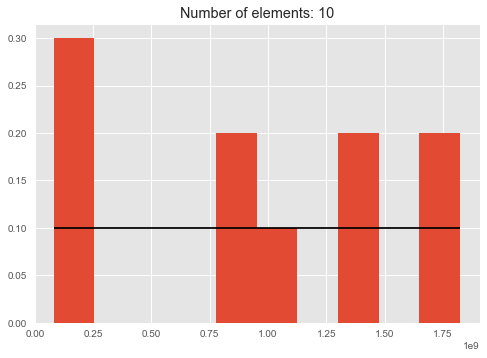

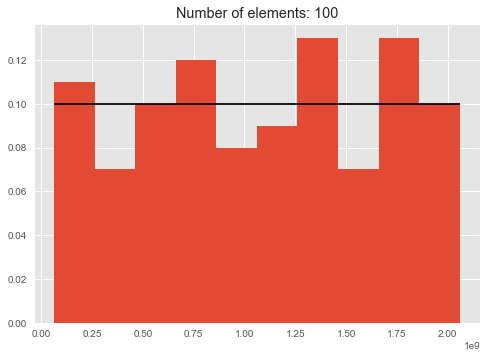

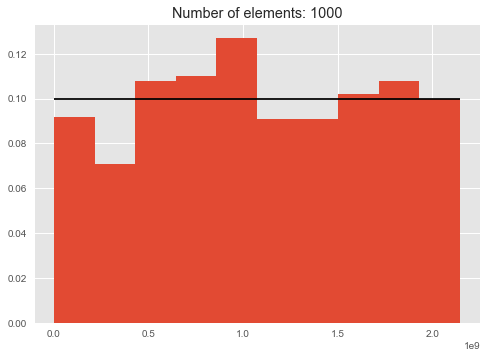

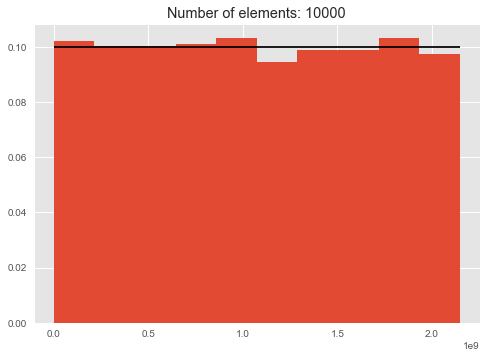

In [159]:
counts = [10, 100, 1000, 10000]
uniform_diffs = plot_uniform_distributions(gen, counts)

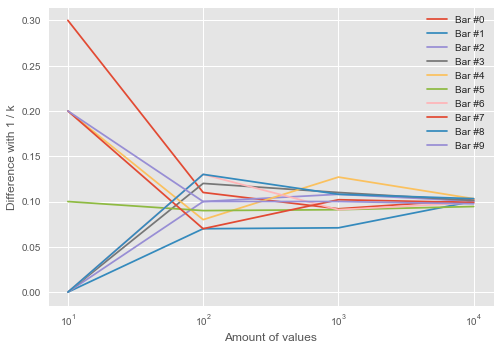

In [160]:
plot_uniform_diffs(uniform_diffs, counts)

### Проверим независимость

In [125]:
def expectation(z):
    return sum(z) / len(z)


def dispersion(z):
    mx = expectation(z)
    return sum((z - mx) ** 2) / (len(z) - 1)


def conditional_expectation(x, y):
    n = len(x)
    return sum(x[i] * y[i] for i in range(n)) / n


def find_covariance(z, n, s=3):
    n = len(z)
    
    mz = expectation(z)
    dz = dispersion(z)
    
    x = [z[i] for i in range(n - s)]
    y = [z[i] for i in range(s, n)]
    mxy = conditional_expectation(x, y)
    
    return (mxy - mz * mz) / dz

In [126]:
for ind_n in [10, 100, 1000, 10000, 100000]:
    z = build_sample(ind_n)
    covariance = find_covariance(z, ind_n)
    
    print('n: {:6}, r: {}'.format(n, covariance))

n:  10000, r: 1.1382862831393785
n:  10000, r: 0.05456489204220971
n:  10000, r: 0.012604188727367257
n:  10000, r: -0.0009028618267833744
n:  10000, r: -0.0005938205366000003


#### Начальные параметры для гистограмм

In [127]:
def get_bins_count(n):
    if n <= 100: return int(np.sqrt(n))
    return 4 * int(np.log(n))

n = 10000
segments = get_bins_count(n)

### Распределение Парето

In [139]:
x0 = 1
alpha = 2

def build_pareto_sample(n, x0, alpha):
    return sorted(par.next(x0, alpha) for _ in range(n))


def build_pareto_var(n, x0, alpha):
    ranges = (0, 15)

    x_var = build_pareto_sample(n, x0, alpha)
    x_var = [x for x in x_var if x >= ranges[0] and x <= ranges[1]]
    return np.array(x_var)

In [164]:
x_var = build_pareto_var(n, x0, alpha)
n = len(x_var)

### Равноинтервальная гистограмма

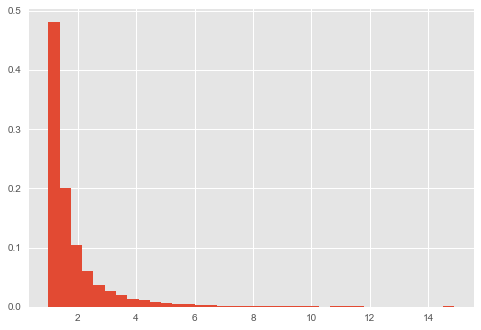

In [161]:
weights = np.ones_like(x_var) / len(x_var)
vals, bins, patches = plt.hist(x_var, bins=segments, weights=weights)

In [149]:
def get_val_counts(arr):
    counts = {}
    for x in arr:
        counts[x] = counts.get(x, 0) + 1
        
    return counts

def build_distribution_function(x_var):
    counts = get_val_counts(x_var)
    
    F = [0]
    for i in range(len(x_var) - 1):
        F.append(F[i] + counts[x_var[i]] / n)
        
    return F

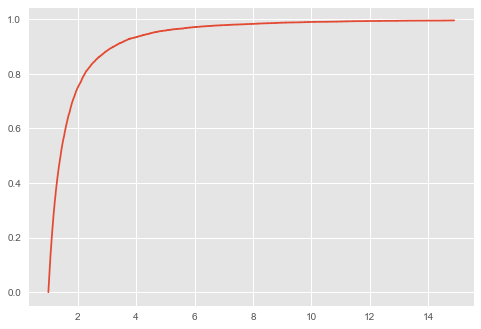

In [162]:
F = build_distribution_function(x_var) 
_ = plt.step(x_var, F)

### Равновероятностная гистограмма

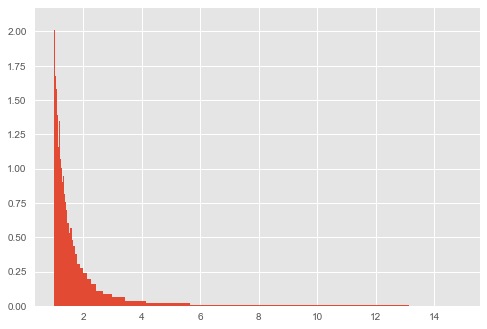

In [163]:
def generate_borders(x_var, segmants):
    n = len(x_var)
    res = [x_var[0]]
    for i in range(n // segments - 1, n - 1, n // segments):
        res.append((x_var[i] + x_var[i + 1]) / 2)
    res.append(x_var[-1])
    return res

borders_eq = generate_borders(x_var, segments)

vals_int, bins_int, patches_int = plt.hist(x_var_f, bins=borders_eq, density=True)

### Точечная оценка матожидания

In [165]:
m_p = sum(x_var) / n
m_p

1.874951812436398

### Точечная оценка дисперсии

In [167]:
d_p = np.sum((x_var - m_p)**2) / (n - 1)
print(d_p)

1.9313365130013185


### Интервальная оценка матожидания

In [67]:
import scipy.stats

laplace = [(x, scipy.stats.norm.cdf(x) - 0.5) for x in np.arange(0, 5, 0.01)]

def find_x_laplace(u):
    good_x = 0
    min_d = 10
    for x, y in laplace:
        if abs(u - y) < min_d:
            min_d = abs(u - y)
            good_x = x
    return good_x

print(find_x_laplace(0.4418))

1.57


### Точечная оценка медианы

In [41]:
def find_median(bins, vals):
    med_amount = sum(vals) / 2
    h = bins[1] - bins[0]
    cur_sum = 0
    i = 0
    while cur_sum < med_amount:
        cur_sum += vals[i]
        i += 1

    return bins[i] + h * (med_amount - cur_sum + vals[i]) / vals[i]

med_p = find_median(bins, vals)
print(med_p)

1.7190398886827458


### Точечная оценка моды

In [ ]:
def find_mode(bins, vals):
    mode_pos = 0
    max_val = 0
    h = bins[1] - bins[0]
    
    for i, val in enumerate(vals):
        if val > max_val:
            max_val = val
            mode_pos = i
   
    prev_pos = i - 1 if i - 1 >= 0 else 0
    next_pos = i + 1 if i + 1 < len(vals) else 0
    
    return bins[mode_pos] + h * (vals[mode_pos] - vals[prev_pos]) / (vals[mode_pos] - vals[prev_pos] + vals[mode_pos] - vals[next_pos])

mod_p = find_mode(bins, vals)
print(mod_p)

In [ ]:
def get_median_confidense(x_var, a=0.05):
    n = len(x_var)
    if a == 0.1:
        k = 0.5 * (n - 1.64 * np.sqrt(n) - 1)
    if a == 0.05:
        k = 0.5 * (n - 1.96 * np.sqrt(n) - 1)
    if a == 0.01:
        k = 0.5 * (n - 2.58 * np.sqrt(n) - 1)
    
    k = int(k)
    return x_var[k], x_var[n - k + 1]

get_median_confidense(x_var_f)

### Проверим критерий согласия Пирсона

In [ ]:
import math

# distribution function
def get_F(x0, gamma):
    def F(x):
        return 1 / math.pi * np.arctan((x - x0) / gamma) + 1 / 2
    
    return F

def pearson_chi(bins, vals, F):
    n = sum(vals)
    chi = 0
    for i in range(len(bins) - 1):
        l = bins[i]
        r = bins[i + 1]
        pi_s = F(r) - F(l)
        pi = vals[i] / n
        chi += (pi - pi_s)**2 / pi
    
    return chi * len(bins)


from scipy.stats import chi2

chi_sqr = pearson_chi(bins, vals, get_F(x0, gamma))
table_pearson = chi2.ppf(0.05, len(bins))
print('Experimental chi square: {cs}, Table chi square: {ts}'.format(cs=chi_sqr, ts=table_pearson))
if chi_sqr < table_pearson:
    print('Good')